In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Persistent Resource Getting Started (SDK)

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/persistent_resource/00_persistent_resource_getting_started_sdk.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fcommunity%2Fpersistent_resource%2F00_persistent_resource_getting_started_sdk.ipynb">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/persistent_resource/00_persistent_resource_getting_started_sdk.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/persistent_resource/00_persistent_resource_getting_started_sdk.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>        
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.10

## Overview

A Vertex AI persistent resource is a long-running cluster you can use to submit multiple Vertex AI Training jobs. You can use a persistent resource to ensure compute resource availability and to reduce the job startup time that's otherwise needed to provision compute resources.

Learn more about [Vertex AI Persistent Resources](https://cloud.google.com/vertex-ai/docs/training/persistent-resource-overview).

### Objective

In this tutorial, you learn how to create a persistent resouce and use the persistent resource as a target for submitting a custom training job. You'll also see how the cluster can auto-expand to pull in additional resources. The Google Cloud CLI (`gcloud`) and [Vertex AI SDK](https://pypi.org/project/google-cloud-aiplatform) will be used to manage resources.

This tutorial uses the following Google Cloud ML services and resources:

- Cloud Build
- Vertex AI Persistent Resource
- Vertex AI Training


The steps performed include:

- Create a persistent resource with autoscaling
- Build and push the custom training job container image
- Create a custom training job on the persistent resource
- Test autoscaling

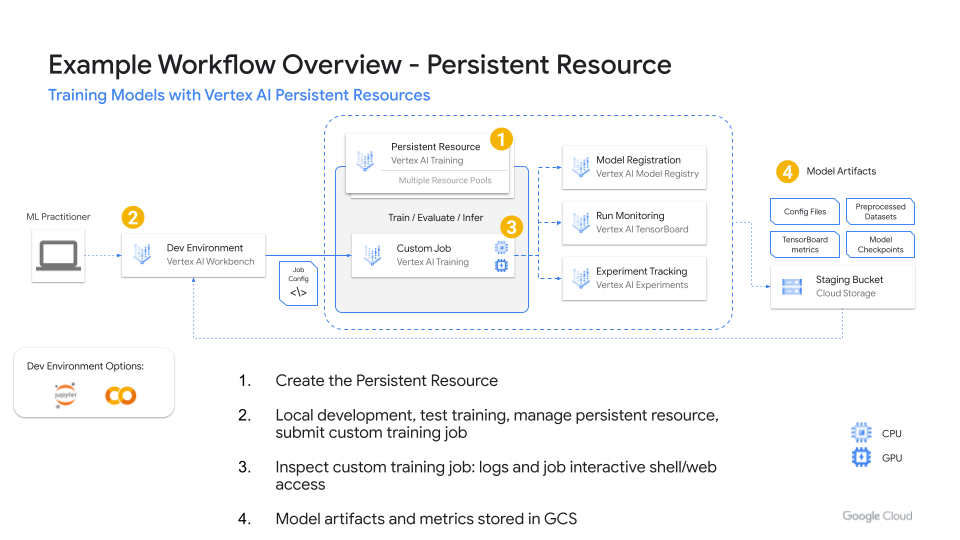

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Build
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
[Cloud Build pricing](https://cloud.google.com/build/pricing),
and [Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Get started

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI, Arifact Registry and Cloud Build APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,cloudbuild.googleapis.com,artifactregistry.googleapis.com).

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk) and the [Vertex AI SDK](https://pypi.org/project/google-cloud-aiplatform/).

### Install Vertex AI SDK for Python and other required packages


In [ ]:
! pip3 install --upgrade --quiet google-cloud-aiplatform

In [ ]:
# Ensure your gcloud is 438.0 or later
!gcloud --version

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [ ]:
import sys

# Authenticate user to Google Cloud
if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK for Python

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
REGION = "us-central1"  # @param {type: "string"}
LOCATION = str(REGION)

# Adjust storage bucket as needed, it will be created in the next step
BUCKET_URI = f"gs://{PROJECT_ID}-persistent-resource"

# Initialize Vertex AI SDK for Python
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

In [ ]:
# Set the project id
!gcloud config set project {PROJECT_ID}

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
!gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

### Import libraries

In [ ]:
import json
import os
import sys
import uuid

from google.cloud import aiplatform
from google.cloud.aiplatform import jobs, persistent_resource

### Training code container definition

In [ ]:
# Clone sample code repo locally
!git clone https://github.com/GoogleCloudPlatform/vertex-ai-samples.git

In [ ]:
# Training code container def
CONTAINER_DIR = "vertex-ai-samples/notebooks/community/persistent_resource/training_code/mpg_container"

Verify the location where the training code exists

In [ ]:
# Print the location where the training code exists, will be used to create the artifact registry container
print(f"Local container directory with training code: {CONTAINER_DIR}")
print("Check whether the container directory exists:", os.path.exists(CONTAINER_DIR))

In [ ]:
# Repo to create / use for running training job
PRIVATE_REPO = "mpg-training"
TRAIN_IMAGE = (
    f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PRIVATE_REPO}/tf-mpg-training:latest"
)
print("Private Repo:", PRIVATE_REPO)
print("Training Container Image:", TRAIN_IMAGE)

### Persistent Resource definition

In [ ]:
# ----------- Name your Persistent Resource -----------#
PERSISTENT_RESOURCE_NAME = "persistent-resource-autoscaling"  # @param {type:"string"}

In [ ]:
# Persistent Resources must have a unique ID
PERSISTENT_RESOURCE_ID = f"{PERSISTENT_RESOURCE_NAME}-{str(uuid.uuid4().hex)[:4]}"

In [ ]:
print(PERSISTENT_RESOURCE_ID)

### Resource Pool Spec definition

In [ ]:
# ----------- Set Resource Pool Spec -----------#
#
# Edit the cluster config below if you want.
#
# Note that, if you specify any GPU pool, please ensure that the machine type
# is compatible with the accelerator type, for example, A100 GPU can only work
# on A2 machine types.
# See more detalis in https://cloud.google.com/compute/docs/gpus#nvidia_gpus_for_compute_workloads

CPU_MACHINE_TYPE = "n1-standard-4"  # @param {type:"string"}
CPU_REPLICA_COUNT = 1  # @param {type:"integer"}
CPU_MIN_REPLICA_COUNT = 1  # @param {type:"integer"}
CPU_MAX_REPLICA_COUNT = 4  # @param {type:"integer"}

In [ ]:
# The list of resource pools to create for the PersistentResource.
MACHINE_SPEC = {
    "machine_type": CPU_MACHINE_TYPE,
}

AUTOSCALED_RESOURCE_POOL = {
    "machine_spec": MACHINE_SPEC,
    "autoscaling_spec": {
        "min_replica_count": CPU_MIN_REPLICA_COUNT,
        "max_replica_count": CPU_MAX_REPLICA_COUNT,
    },
}

# Optional labels with user-defined metadata to organize the PersistentResource.
LABELS = {"presistent_resource": "true"}

# Whether to execute this method synchonously. If False, this method will be
# executed in concurrent Future and any downstream object will be immediately
# returned and synced when the Future has completed.
SYNC = False

## Create a Persistent Resource with autoscaling

Let's create a persistent resource with one CPU pool and autoscaling.

Make the request to [create your persistent resource](https://cloud.google.com/vertex-ai/docs/training/persistent-resource-create):

In [ ]:
# Create the persistent resource. This method returns the created resource.
persistent_resource_instance = persistent_resource.PersistentResource.create(
    persistent_resource_id=PERSISTENT_RESOURCE_ID,
    display_name=PERSISTENT_RESOURCE_NAME,
    resource_pools=[AUTOSCALED_RESOURCE_POOL],
    labels=LABELS,
    sync=SYNC,
)

if not SYNC:
    persistent_resource_instance.wait()

Check presistent resource creation LRO status and wait is shows `State.RUNNING`

In [ ]:
persistent_resource_instance.state

### Get Persistent Resource details

[Get information about a specific persistent resource](https://cloud.google.com/vertex-ai/docs/training/persistent-resource-get).

In [ ]:
persistent_resource_instance = persistent_resource.PersistentResource(
    PERSISTENT_RESOURCE_ID
)

print(persistent_resource_instance.display_name)
print(persistent_resource_instance.state)
print(persistent_resource_instance.start_time)

### List all the Persistent Resources under your project

In [ ]:
# Optional arguments:
# filter (str): An expression for filtering the results of the request. For
#   field names both snake_case and camelCase are supported.
# order_by (str): A comma-separated list of fields to order by, sorted in
#   ascending order. Use "desc" after a field name for descending. Supported
#   fields: `display_name`, `create_time`, `update_time`

# List the persistent resource on the project.
persistent_resource_list = persistent_resource.PersistentResource.list()

for i in range(len(persistent_resource_list)):
    print(persistent_resource_list[i].name)
    print(persistent_resource_list[i].state)

### View details about your Persistent Resource

In [ ]:
persistent_resource_instance = persistent_resource.PersistentResource(
    PERSISTENT_RESOURCE_ID
)

print(json.dumps(persistent_resource_instance.to_dict(), sort_keys=False, indent=2))

## Run custom training jobs on the Persistent Resource

You must have enabled `Artifact Registry` and `Cloud Build` APIs for your project during the **Before you begin** section. You will store the custom training container in Artifact Registry.

### Create a private Docker repository
Your first step is to create a Docker repository in Artifact Registry.

1 - Run the `gcloud artifacts repositories create` command to create a new Docker repository with your region with the description `Docker repository`.

2 - Run the `gcloud artifacts repositories list` command to verify that your repository was created.

In [ ]:
print("Private Repo:", PRIVATE_REPO)
print("Deployment:", TRAIN_IMAGE)

In [ ]:
!gcloud artifacts repositories create {PRIVATE_REPO} --repository-format=docker --location={REGION} --description="Docker repository"

In [ ]:
!gcloud artifacts repositories list

### Build and push the custom docker container image by using Cloud Build

Build and push a Docker image with Cloud Build

In [ ]:
!cd $CONTAINER_DIR && gcloud builds submit --timeout=1800s --region={REGION} --tag $TRAIN_IMAGE

### Prepare training jobs

Vertex AI Training supports submiting custom training jobs with a prebuilt container, custom container and python application via **HTTP request, Vertex AI SDK or gcloud CLI**. Learn more [here](https://cloud.google.com/vertex-ai/docs/training/code-requirements).

In this example, we will demonstrate how to [run a custom job on a persistent resource](https://cloud.google.com/vertex-ai/docs/training/persistent-resource-train). Please specify the images below to your custom images.
Note, if it's not a public image, please ensure it's already pushed to your project.

https://cloud.google.com/vertex-ai/docs/training/containers-overview

In [ ]:
# Prepare training images
TRAINING_CONTAINER_IMAGE = str(TRAIN_IMAGE)
JOB_DIR = str(BUCKET_URI)
print("Using image: ", TRAINING_CONTAINER_IMAGE)
print("Output Model Directory: ", JOB_DIR)

In [ ]:
JOB_DISPLAY_NAME = "persistent-resource-job-001"  # @param {type:"string"}
RUN_ARGS = [f"--job-dir={JOB_DIR}"]

# ----------- Set WorkerPool Spec -----------#
WORKER_POOL_SPEC = [
    {
        "machine_spec": MACHINE_SPEC,
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAINING_CONTAINER_IMAGE,
            "command": [],
            "args": RUN_ARGS,
        },
    }
]

# Indicates if the job should retry for internal errors after the job starts running
DISABLE_RETRIES = True

# The maximum job running time in seconds
TIMEOUT = 8000

### Create single-replica CPU jobs

In [ ]:
# ----------- Create A Single CPU node Training Job -----------#
LABELS = {"presistent_resource_job": "true"}

# Constructs a Custom Job with Worker Pool Specs
job = jobs.CustomJob(
    display_name=JOB_DISPLAY_NAME,
    worker_pool_specs=WORKER_POOL_SPEC,
    labels=LABELS,
    persistent_resource_id=PERSISTENT_RESOURCE_ID,
)

# Run this configured CustomJob
job.run(
    timeout=TIMEOUT,
    sync=SYNC,
    create_request_timeout=None,
    disable_retries=DISABLE_RETRIES,
)

# Waits until resource has been created
job.wait_for_resource_creation()

# This job.wait() method will block until other operations are complete
# https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.CustomJob#google_cloud_aiplatform_CustomJob_wait
# job.wait()

In [ ]:
# Fetch Job and return the current JobState
job.state

### Get single-replica CPU job status

In [ ]:
# Option 1: Use the Custom Job Display Name to get details
jobs_list = job.list(filter=f"display_name={JOB_DISPLAY_NAME}")

for job_instance in jobs_list:
    print(json.dumps(job_instance.to_dict(), sort_keys=False, indent=2))

In [ ]:
# Option 2: List existing custom jobs, filter on running jobs and ones with the set label
# Lists the existing custom jobs, filters with the label set for these jobs

FILTER = '(state!="JOB_STATE_SUCCEEDED" AND state!="JOB_STATE_FAILED" AND state!="JOB_STATE_CANCELLED") AND labels.presistent_resource_job=true'
jobs_list = job.list(filter=FILTER)

for job_instance in jobs_list:
    print(json.dumps(job_instance.to_dict(), sort_keys=False, indent=2))

## Test Autoscaling
This section tests autoscalling. Steps run below:
1. Check there are no used replicas on the persistent resource.
2. Submit 4 Single CPU Replica custom training jobs on the persistent resource.
3. Get the persistent resource details to inspect used replicas.
4. You can also inspect the running jobs in Vertex AI Training

### Check usedReplicaCount on the Persistent Resource

In [ ]:
# If usedReplicaCount is not shown, you're good to go. If you see usedReplicaCount >=1 a job is still running
resource_to_get = persistent_resource.PersistentResource(PERSISTENT_RESOURCE_ID)

print(json.dumps(resource_to_get.to_dict(), sort_keys=False, indent=2))

### Submit 4 single CPU replica jobs

In [ ]:
# Submit 4 Single CPU Replica jobs, the cluster should scale up to maxReplicaCount of 4
LABELS = {"presistent_resource_job": "true"}
jobs_list = []
for i in range(1, 5):
    print(f"Submitting custom training job {str(i).zfill(3)}")
    JOB_DISPLAY_NAME = f"persistent-resource-job-{str(i).zfill(3)}"

    # Constructs a Custom Job with Worker Pool Specs
    job = jobs.CustomJob(
        display_name=JOB_DISPLAY_NAME,
        worker_pool_specs=WORKER_POOL_SPEC,
        labels=LABELS,
        persistent_resource_id=PERSISTENT_RESOURCE_ID,
    )

    # Run this configured CustomJob
    job.run(
        timeout=TIMEOUT,
        sync=SYNC,
        create_request_timeout=None,
        disable_retries=DISABLE_RETRIES,
    )

    # Waits until resource has been created
    job.wait_for_resource_creation()

    jobs_list.append(job)

In [ ]:
# ----------- Check Vertex AI Training Custom Jobs -----------#
print("You may go to the below uri to check submitted jobs.")
print(
    f"https://console.cloud.google.com/vertex-ai/training/custom-jobs?project={PROJECT_ID}"
)

In [ ]:
print(len(jobs_list))
for job_instance in jobs_list:
    # Fetch Job and return the current JobState
    print(job_instance.state)

### Get Persistent Resource details

In [ ]:
# Check the usedReplicaCount field on the persistent resource
resource_to_get = persistent_resource.PersistentResource(PERSISTENT_RESOURCE_ID)

print(json.dumps(resource_to_get.to_dict(), sort_keys=False, indent=2))

### Get active jobs on the Persistent Resource

In [ ]:
FILTER = '(state!="JOB_STATE_SUCCEEDED" AND state!="JOB_STATE_FAILED" AND state!="JOB_STATE_CANCELLED") AND labels.presistent_resource_job=true'
jobs_list = job.list(filter=FILTER)

for job_instance in jobs_list:
    print(json.dumps(job_instance.to_dict(), sort_keys=False, indent=2))

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Cloud Storage Bucket
- Artifacts Repository
- Vertex AI Persistent Resource

In [ ]:
import os

# Delete Cloud Storage objects that were created
delete_bucket = False
# Delete the Artifact Registry Repo
delete_artifacts_repo = False
# Delete the Vertex AI Persistent Resource
delete_persistent_resource = True

# Whether to execute this method synchonously. If False, this method will be
# executed in concurrent Future and any downstream object will be immediately
# returned and synced when the Future has completed.
SYNC = False

if delete_bucket or os.getenv("IS_TESTING"):
    !gsutil -m rm -r $BUCKET_URI

if delete_persistent_resource:
    resource_to_delete = persistent_resource.PersistentResource(PERSISTENT_RESOURCE_ID)

    # Delete the persistent resource.
    resource_to_delete.delete(sync=SYNC)

    if not SYNC:
        resource_to_delete.wait()

if delete_artifacts_repo:
    !gcloud artifacts repositories delete {PRIVATE_REPO} --location={REGION} --quiet

### List all Persistent Resources
Get list of persistent resources to make sure they're deleted

In [ ]:
# List all the persistent resources under your project
persistent_resource_list = persistent_resource.PersistentResource.list()
for persistent_resource_instance in persistent_resource_list:
    print(json.dumps(persistent_resource_instance.to_dict(), sort_keys=False, indent=2))